In [3]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import math
import random
import pandas as pd
from pyomo.opt import SolverFactory
from pyomo.core import Var
import pyomo.environ as en
import seaborn as sns
import time
import os
import pickle

In [6]:
currentDir = os.getcwd()
fs = 12

In [7]:
with open('./IntermediateData/optimalParams.pickle', 'rb') as inFile:
    optimalParams = pickle.load(inFile)
with open('./IntermediateData/reducedGenMatrix.pickle', 'rb') as inFile:
    genMatrixR = pickle.load(inFile)

In [9]:
np.around(optimalParams, decimals=1)

array([[[ 6.7,  0.3,  7.4,  4. ,  0.9,  0. ],
        [ 1.2,  0.3,  7.3, 18.1,  1.6,  0. ]],

       [[ 6.1,  0. ,  3.5,  5.6,  1. ,  0. ],
        [ 1.2,  0.5,  5. , 20. ,  1. ,  0. ]],

       [[ 6.1,  0. ,  2.6,  6.3,  1.3,  0. ],
        [ 1. ,  0.3,  3.9, 20. ,  0.5,  0. ]],

       [[ 7.1,  0. ,  2.4,  5.7,  1.9,  0. ],
        [ 0.9,  0.6,  6.7, 20. ,  1. ,  0. ]]])

In [173]:
demand = np.sum(genMatrixR, axis=1)
wind = genMatrixR[:,-1]

In [174]:
### get the model dispatch
def FCEC_baseload(demandPeriod, plantCapsBaseload, windPeriod):
    # get the dispatch based on the demand
    
    pC = plantCapsBaseload.astype(float)
    
    genLevels = np.zeros((np.shape(pC)))
    maxLevels = np.cumsum(pC, axis=1)
    
    # make sure demand isnt less than baseload
    if demandPeriod < maxLevels[0,-1]:
        diffs = maxLevels[0] - demandPeriod
        marginIndex = np.where(diffs>=0)[0][0]
        
        genLevels[0,np.where(diffs<0)] = pC[0,np.where(diffs<0)]
        if marginIndex>0:
            genLevels[0,marginIndex] = demandPeriod - maxLevels[0,marginIndex-1]
        else:
            genLevels[0,marginIndex] = demandPeriod
        curtailed = windPeriod

        
    else:
        genLevels[0,:] = pC[0,:]
        demandPeriod = demandPeriod - maxLevels[0,-1]
        
        # subtract the wind
        if demandPeriod<=windPeriod:
            curtailed = windPeriod - demandPeriod
            demandPeriod = 0
            
        else:
            curtailed = 0
            demandPeriod = demandPeriod - windPeriod
            
            if demandPeriod<maxLevels[1,-1]:

                diffs = maxLevels[1] - demandPeriod
                marginIndex = np.where(diffs>=0)[0][0]

                genLevels[1,np.where(diffs<0)] = pC[1,np.where(diffs<0)]
                if marginIndex>0:
                    genLevels[1,marginIndex] = demandPeriod - maxLevels[1,marginIndex-1]
                else:
                    genLevels[1,marginIndex] = demandPeriod
                    
            else:
                genLevels[1,:] = pC[1,:]

    return np.sum(genLevels, axis=0), curtailed

In [175]:
Winter_start = 0
Winter_end = (np.round(365/4)+1)*48
Spring_start = Winter_end
Spring_end = Winter_end + np.round(365/4)*48
Summer_start = Spring_end
Summer_end = Spring_end + np.round(365/4)*48
Autumn_start = Summer_end
Autumn_end = Summer_end + np.round(365/4)*48

seasonMarkers = np.array([Winter_start, Spring_start, Summer_start, Autumn_start, Autumn_end])
seasonMarkers = np.asarray([np.int(s) for s in seasonMarkers])

seasons = ['winter', 'spring', 'summer', 'autumn']

In [176]:
plantCapsBaseload=optimalParams[0]
wind = genMatrixR[:,-1]
demandNetWind = demand - wind

In [177]:
for j,season in enumerate(seasons):
    print (season+' max generating capacity is %.1f'%np.sum(optimalParams[j])+'GW')
    print (season+' max demand is %.1f'%np.max(demand[seasonMarkers[j]:seasonMarkers[j+1]])+'GW')
    print (season+' max demand net wind is %.1f'%np.max(demandNetWind[seasonMarkers[j]:seasonMarkers[j+1]])+'GW')
modelMix = np.zeros((len(demand),np.size(plantCapsBaseload, 1)))

curtailed = np.zeros(np.shape(demand))
for j in range(len(demand)):
    # get the dispatch based on the demand
    seasonIndex = np.digitize(j, seasonMarkers)-1 
    modelMix[j], curtailed[j] = \
    FCEC_baseload(demand[j], plantCapsBaseload=optimalParams[seasonIndex], windPeriod=wind[j])

winter max generating capacity is 47.7GW
winter max demand is 49.5GW
winter max demand net wind is 49.0GW
spring max generating capacity is 43.9GW
spring max demand is 36.0GW
spring max demand net wind is 35.4GW
summer max generating capacity is 42.0GW
summer max demand is 37.4GW
summer max demand net wind is 36.0GW
autumn max generating capacity is 46.3GW
autumn max demand is 47.3GW
autumn max demand net wind is 44.8GW


In [178]:
### EMISSIONS in g/kWh (= tonnes/GWh)
emissions = np.array([16., # nuclear
                     20.,  # hydro
                     870., # coal
                     487., # CCGT
                     600., # other
                     650., # OCGT
                     11.]) # wind
# ### FUEL Costs in GBP/MWh 
fuelCosts = np.array([10.,  # nuclear
                     3.,  # hydro
                     26., # coal
                     40., # CCGT
                     70.,  # other
                     60.,  # OCGT
                     0.])  # wind

In [179]:
totalGWh = np.sum(genMatrixR, axis=0)
tonnesAnnualType = totalGWh*emissions
avEmissions = np.sum(tonnesAnnualType)/np.sum(totalGWh)
print ('estimate that carbon intensity of UK grid is %.2f'%(avEmissions)+' g/kWh')

estimateMix = np.zeros((np.shape(genMatrixR)))
estimateMix[:,:-1] = modelMix
estimateMix[:,-1] = wind-curtailed
totalGWh = np.sum(estimateMix, axis=0)
tonnesAnnualType = totalGWh*emissions
avEmissions = np.sum(tonnesAnnualType)/np.sum(totalGWh)
print ('model estimate that carbon intensity of UK grid is %.2f'%(avEmissions)+' g/kWh')

estimate that carbon intensity of UK grid is 433.15 g/kWh
model estimate that carbon intensity of UK grid is 433.05 g/kWh


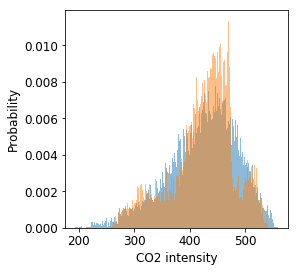

In [180]:
def demand_histogram(demand):
    upperVal = np.ceil(np.max(demand)/1)*1
    lowerVal = np.floor(np.min(demand)/1)*1
    demandBins = np.arange(lowerVal, upperVal+1, 1)
    hist, edges = np.histogram(demand, bins=demandBins)
    centres = edges[0:-1]+(edges[1:]-edges[0:-1])/2.
    widths = edges[1:]-edges[0:-1]
    return hist, centres, widths

def axis_format(axis, labX, labY, fs):
    axis.set_xlabel(labX, fontsize=fs)
    axis.set_ylabel(labY, fontsize=fs)
    axis.tick_params(axis='both', labelsize=fs)

### plot a histogram of carbon intensity
carbonByPeriod = np.sum(genMatrixR*emissions, axis=1)/np.sum(genMatrixR, axis=1)
hist, centres, widths = demand_histogram(carbonByPeriod)
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111)
ax1.bar(centres, hist/np.float(np.sum(hist)), width=widths, alpha=0.5)

carbonByPeriod = np.sum(estimateMix*emissions, axis=1)/np.sum(estimateMix, axis=1)
hist, centres, widths = demand_histogram(carbonByPeriod)
ax1.bar(centres, hist/np.float(np.sum(hist)), width=widths, alpha=0.5)

labX = 'CO2 intensity'
labY = 'Probability'
axis_format(ax1, labX, labY, fs)

(168, 336)

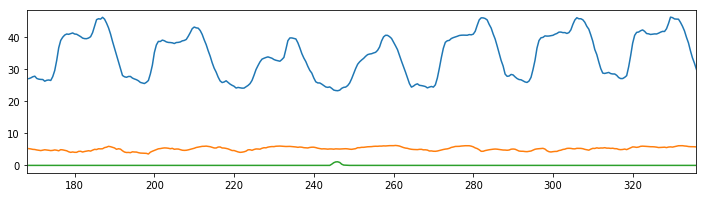

In [181]:
window = [168,168*2]
times = np.arange(window[0]+0.5,window[1]+0.1,0.5)
fig = plt.figure(figsize=(12,3))
plt.plot(times, demand[window[0]*2:window[1]*2])
plt.plot(times, wind[window[0]*2:window[1]*2])
plt.plot(times, curtailed[window[0]*2:window[1]*2])
plt.xlim([window[0], window[1]])

In [182]:
np.sum(plantCapsBaseload, axis=0) 

array([ 7.87989451,  0.64461651, 14.62465582, 22.10489326,  2.49143991,
        0.        ])

In [183]:
### here choose whether to allow storage to replace flex
plantMaxCap = np.zeros((np.shape(modelMix)))
plantMinCap = np.zeros((np.shape(modelMix)))
for j,season in enumerate(seasons):
    plantMaxCap[seasonMarkers[j]:seasonMarkers[j+1],:] = np.sum(optimalParams[j], axis=0) 
    plantMinCap[seasonMarkers[j]:seasonMarkers[j+1],:] = optimalParams[j][0]

In [184]:
### storage parameters
maxCapacity = 20. # GWh
maxCapacity = maxCapacity*2
maxCharge = 2.5 # GW
maxDischarge = -2.5 # GW
chargeEff = 0.866
dischargeEff = 0.866

In [185]:
def create_model(costs, demand, modelMix, curtailed, maxCapacity, maxCharge, maxDischarge, chargeEff, dischargeEff, \
                plantMaxCap, plantMinCap):

    # now set up the pyomo model
    m = en.ConcreteModel()

    # time is what we will use as the model index
    m.Time = en.RangeSet(0, len(demand)-1)

    ### initialise the actual generation values based on modelMix
    dictNuc = dict(enumerate(modelMix[:,0]))
    dictHyd = dict(enumerate(modelMix[:,1]))
    dictCoa = dict(enumerate(modelMix[:,2]))
    dictCCG = dict(enumerate(modelMix[:,3]))
    dictOth = dict(enumerate(modelMix[:,4]))
    dictOCG = dict(enumerate(modelMix[:,5]))

    dictCur = dict(enumerate(curtailed))

    # variables (all indexed by Time)
    m.SOC = en.Var(m.Time, bounds=(0.,maxCapacity), initialize=0.) 
    m.posDeltaSOC = en.Var(m.Time, bounds=(0.,maxCharge), initialize=0.) 
    m.negDeltaSOC = en.Var(m.Time, bounds=(maxDischarge,0.), initialize=0.) 

    ### now include the energy into storage from each genType
    m.posEInNuc = en.Var(m.Time, bounds=(0., maxCharge/chargeEff), initialize=0.) 
    m.posEInHyd = en.Var(m.Time, bounds=(0., maxCharge/chargeEff), initialize=0.)
    m.posEInCoa = en.Var(m.Time, bounds=(0., maxCharge/chargeEff), initialize=0.) 
    m.posEInCCG = en.Var(m.Time, bounds=(0., maxCharge/chargeEff), initialize=0.)

    m.posEInOth = en.Var(m.Time, bounds=(0., maxCharge/chargeEff), initialize=0.) 
    m.posEInOCG = en.Var(m.Time, bounds=(0., maxCharge/chargeEff), initialize=0.)

    m.posEInCur = en.Var(m.Time, bounds=(0., maxCharge/chargeEff), initialize=0.)

    ### now include the energy out of storage from each genType
    m.negEOutNuc = en.Var(m.Time, bounds=(maxDischarge, 0.),  initialize=0.)
    m.negEOutHyd = en.Var(m.Time, bounds=(maxDischarge, 0.),  initialize=0.)
    m.negEOutCoa = en.Var(m.Time, bounds=(maxDischarge, 0.),  initialize=0.) 
    m.negEOutCCG = en.Var(m.Time, bounds=(maxDischarge, 0.),  initialize=0.)

    m.negEOutOth = en.Var(m.Time, bounds=(maxDischarge, 0.),  initialize=0.) 
    m.negEOutOCG = en.Var(m.Time, bounds=(maxDischarge, 0.),  initialize=0.)

    ### Storage cannot replace wind or curtailed wind

    # ### initialise the bounds
    dictMaxNuc = dict(enumerate(plantMaxCap[:,0]))
    dictMinNuc = dict(enumerate(plantMinCap[:,0]))
    dictMaxHyd = dict(enumerate(plantMaxCap[:,1]))
    dictMinHyd = dict(enumerate(plantMinCap[:,1]))
    dictMaxCoa = dict(enumerate(plantMaxCap[:,2]))
    dictMinCoa = dict(enumerate(plantMinCap[:,2]))
    dictMaxCCG = dict(enumerate(plantMaxCap[:,3]))
    dictMinCCG = dict(enumerate(plantMinCap[:,3]))

    dictMaxOth = dict(enumerate(plantMaxCap[:,4]))
    dictMinOth = dict(enumerate(plantMinCap[:,4]))
    dictMaxOCG = dict(enumerate(plantMaxCap[:,5]))
    dictMinOCG = dict(enumerate(plantMinCap[:,5]))

    ### the MIN and MAX limits of each gen type are parameters (indexed by time)
    m.minNuc = en.Param(m.Time, initialize=dictMinNuc)
    m.maxNuc = en.Param(m.Time, initialize=dictMaxNuc)
    m.minHyd = en.Param(m.Time, initialize=dictMinHyd)
    m.maxHyd = en.Param(m.Time, initialize=dictMaxHyd)
    m.minCoa = en.Param(m.Time, initialize=dictMinCoa)
    m.maxCoa = en.Param(m.Time, initialize=dictMaxCoa)
    m.minCCG = en.Param(m.Time, initialize=dictMinCCG)
    m.maxCCG = en.Param(m.Time, initialize=dictMaxCCG)

    m.minOth = en.Param(m.Time, initialize=dictMinOth)
    m.maxOth = en.Param(m.Time, initialize=dictMaxOth)
    m.minOCG = en.Param(m.Time, initialize=dictMinOCG)
    m.maxOCG = en.Param(m.Time, initialize=dictMaxOCG)

    def bounds_Nuc_rule(m, i):
        return (m.minNuc[i], m.maxNuc[i])
    m.netNuc = en.Var(m.Time, bounds=bounds_Nuc_rule, initialize=dictNuc)

    def bounds_Hyd_rule(m, i):
        return (m.minHyd[i], m.maxHyd[i])
    m.netHyd = en.Var(m.Time, bounds=bounds_Hyd_rule, initialize=dictHyd)

    def bounds_Coa_rule(m, i):
        return (m.minCoa[i], m.maxCoa[i])
    m.netCoa = en.Var(m.Time, bounds=bounds_Coa_rule, initialize=dictCoa)

    def bounds_CCG_rule(m, i):
        return (m.minCCG[i], m.maxCCG[i])
    m.netCCG = en.Var(m.Time, bounds=bounds_CCG_rule, initialize=dictCCG)

    def bounds_Oth_rule(m, i):
        return (m.minOth[i], m.maxOth[i])
    m.netOth = en.Var(m.Time, bounds=bounds_Oth_rule, initialize=dictOth)
    def bounds_OCG_rule(m, i):
        return (m.minOCG[i], m.maxOCG[i])
    m.netOCG = en.Var(m.Time, bounds=bounds_OCG_rule, initialize=dictOCG)

    ### wind doesn't change 
    m.netCur = en.Var(m.Time, initialize=dictCur)

    ### STORAGE EFFICIENCY
    m.etaChg = en.Param(initialize = chargeEff)
    m.etaDisChg = en.Param(initialize = dischargeEff)

    m.paramNuc = en.Param(m.Time, initialize=dictNuc)
    m.paramHyd = en.Param(m.Time, initialize=dictHyd)
    m.paramCoa = en.Param(m.Time, initialize=dictCoa)
    m.paramCCG = en.Param(m.Time, initialize=dictCCG)

    m.paramOth = en.Param(m.Time, initialize=dictOth)
    m.paramOCG = en.Param(m.Time, initialize=dictOCG)

    m.paramCur = en.Param(m.Time, initialize=dictCur)

    # Boolean variables (again indexed by Time)
    m.Bool_char=en.Var(m.Time,within=en.Boolean)
    m.Bool_dis=en.Var(m.Time,within=en.Boolean,initialize=0) 

    # we use bigM to bound the problem
    # boolean constraints
    def Bool_char_rule_1(m,i):
        bigM=500000
        return((m.posDeltaSOC[i])>=-bigM*(m.Bool_char[i]))
    m.Batt_ch1=en.Constraint(m.Time,rule=Bool_char_rule_1)
    # if battery is charging, charging must be greater than -large
    # if not, charging geq zero
    def Bool_char_rule_2(m,i):
        bigM=500000
        return((m.posDeltaSOC[i])<=0+bigM*(1-m.Bool_dis[i]))
    m.Batt_ch2=en.Constraint(m.Time,rule=Bool_char_rule_2)
    # if batt discharging, charging must be leq zero
    # if not, charging leq +large
    def Bool_char_rule_3(m,i):
        bigM=500000
        return((m.negDeltaSOC[i])<=bigM*(m.Bool_dis[i]))
    m.Batt_cd3=en.Constraint(m.Time,rule=Bool_char_rule_3)
    # if batt discharge, discharge leq POSITIVE large
    # if not, discharge leq 0
    def Bool_char_rule_4(m,i):
        bigM=500000
        return((m.negDeltaSOC[i])>=0-bigM*(1-m.Bool_char[i]))
    m.Batt_cd4=en.Constraint(m.Time,rule=Bool_char_rule_4)
    # if batt charge, discharge geq zero
    # if not, discharge geq -large
    def Batt_char_dis(m,i):
        return (m.Bool_char[i]+m.Bool_dis[i],1)
    m.Batt_char_dis=en.Constraint(m.Time,rule=Batt_char_dis)

    ####### OBJECTIVE #######
    def Obj_fn(m):
        return sum((m.netNuc[i]*costs[0] + m.netHyd[i]*costs[1] + \
                    m.netCoa[i]*costs[2] + m.netCCG[i]*costs[3] + \
                    m.netOth[i]*costs[4] + m.netOCG[i]*costs[5]) for i in m.Time)
    m.total_cost = en.Objective(rule=Obj_fn,sense=en.minimize)

    ### constraint on state of charge
    def SOC_rule(m,t):
        if t==0:
            return (m.SOC[t] == m.posDeltaSOC[t]+m.negDeltaSOC[t])
        else:
            return (m.SOC[t] == m.SOC[t-1]+m.posDeltaSOC[t]+m.negDeltaSOC[t])   
    # then we specify that this constraint is indexed by time
    m.storage_SOC = en.Constraint(m.Time,rule=SOC_rule)

    ### curtailed rule
    def Max_Cur_rule(m,i):
        return m.netCur[i]>=0.
    m.maxCur_cons = en.Constraint(m.Time, rule=Max_Cur_rule)

    def net_Nuc(m,i):
        return m.netNuc[i] == m.paramNuc[i]+m.posEInNuc[i]+m.negEOutNuc[i]
    m.E_netNuc_cons = en.Constraint(m.Time,rule=net_Nuc)
    def net_Hyd(m,i):
        return m.netHyd[i] == m.paramHyd[i]+m.posEInHyd[i]+m.negEOutHyd[i]
    m.E_netHyd_cons = en.Constraint(m.Time,rule=net_Hyd)
    def net_Coa(m,i):
        return m.netCoa[i] == m.paramCoa[i]+m.posEInCoa[i]+m.negEOutCoa[i]
    m.E_netCoa_cons = en.Constraint(m.Time,rule=net_Coa)
    def net_CCG(m,i):
        return m.netCCG[i] == m.paramCCG[i]+m.posEInCCG[i]+m.negEOutCCG[i]
    m.E_netCCG_cons = en.Constraint(m.Time,rule=net_CCG)

    def net_Oth(m,i):
        return m.netOth[i] == m.paramOth[i]+m.posEInOth[i]+m.negEOutOth[i]
    m.E_netOth_cons = en.Constraint(m.Time,rule=net_Oth)
    def net_OCG(m,i):
        return m.netOCG[i] == m.paramOCG[i]+m.posEInOCG[i]+m.negEOutOCG[i]
    m.E_netOCG_cons = en.Constraint(m.Time,rule=net_OCG)
    
    ### this constraint is different, as CHARGING DOESNT INCREASE curtailed, it DECREASES it
    # m.del_component(m.E_netCur_cons)
    def net_Cur(m,i):
        return m.netCur[i] == m.paramCur[i]-m.posEInCur[i]
    m.E_netCur_cons = en.Constraint(m.Time,rule=net_Cur)

    #ensure charging efficiency is divided
    def pos_E_in_rule(m,i):
        return (m.posEInNuc[i]+m.posEInHyd[i]+m.posEInCoa[i]+m.posEInCCG[i]+\
                +m.posEInOth[i]+m.posEInOCG[i]+\
                m.posEInCur[i]) == m.posDeltaSOC[i]/m.etaChg
    m.posEIn_cons = en.Constraint(m.Time, rule=pos_E_in_rule)
    # ensure discharging eff multiplied
    def neg_E_out_rule(m,i):
        return (m.negEOutNuc[i]+m.negEOutHyd[i]+m.negEOutCoa[i]+m.negEOutCCG[i]+\
                m.negEOutOth[i]+m.negEOutOCG[i]) == m.negDeltaSOC[i]*m.etaDisChg
    m.negEOut_cons = en.Constraint(m.Time, rule=neg_E_out_rule)
    
    return m

In [186]:
def get_model_results(m, modelMix, chargeEff, dischargeEff):
    modelMixSt = np.zeros(np.shape(modelMix))
    modelMixSt[:,0] = np.asarray([m.netNuc[i].value for i in m.Time])
    modelMixSt[:,1] = np.asarray([m.netHyd[i].value for i in m.Time])
    modelMixSt[:,2] = np.asarray([m.netCoa[i].value for i in m.Time])
    modelMixSt[:,3] = np.asarray([m.netCCG[i].value for i in m.Time])
    modelMixSt[:,4] = np.asarray([m.netOth[i].value for i in m.Time])
    modelMixSt[:,5] = np.asarray([m.netOCG[i].value for i in m.Time])
    
    leftOverCurt = np.asarray([m.netCur[i].value for i in m.Time])
    
    storageCharge = np.asarray([m.posDeltaSOC[i].value for i in m.Time])/chargeEff
    storageDischarge = np.asarray([m.negDeltaSOC[i].value for i in m.Time])*dischargeEff
    
    return modelMixSt, leftOverCurt, storageCharge, storageDischarge

In [187]:
mFC = create_model(fuelCosts, demand, modelMix, curtailed, maxCapacity, maxCharge, maxDischarge, chargeEff, dischargeEff, \
                plantMaxCap, plantMinCap)

In [188]:
opt = SolverFactory("cplex", executable="/opt/ibm/ILOG/CPLEX_Studio1271/cplex/bin/x86-64_linux/cplex")

In [189]:
# print('manually calculated objective function %.f'%(np.sum(np.sum(estimateMix[:,:-1], axis=0)*fuelCosts[:-1])))
# print('manually calculated objective function %.f'%mFC.total_cost())

In [190]:
# time it for good measure
t = time.time()
results = opt.solve(mFC)
elapsed = time.time() - t
print('Time elapsed: %.2f'%elapsed)

Time elapsed: 52.13


In [191]:
print('optimsed objective function %.f'%mFC.total_cost())

optimsed objective function 13463164


In [192]:
modelMixStFC, leftOverCurtFC, storageChargeFC, storageDischargeFC = \
get_model_results(mFC, modelMix, chargeEff, dischargeEff)

In [193]:
mEC = create_model(emissions, demand, modelMix, curtailed, maxCapacity, maxCharge, maxDischarge, chargeEff, dischargeEff, \
                plantMaxCap, plantMinCap)

In [194]:
# time it for good measure
t = time.time()
results = opt.solve(mEC)
elapsed = time.time() - t
print('Time elapsed: %.2f'%elapsed)

Time elapsed: 1484.85


In [195]:
modelMixStEC, leftOverCurtEC, storageChargeEC, storageDischargeEC = \
get_model_results(mEC, modelMix, chargeEff, dischargeEff)

In [252]:
modelMixStEC[window[0]]

array([ 7.87989451,  0.64461651, 11.9285362 ,  6.89385774,  0.90793107,
        0.        ])

In [257]:
[mEC.posEInCoa[window[0]+x].value for x in np.arange(0,10)]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

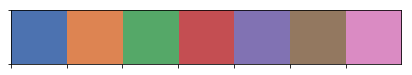

In [249]:
### looking at the model results
colors = sns.color_palette('deep', 7)
sns.palplot(colors)
window = [168+72,168*2]
times = np.arange(window[0]+0.5,window[1]+0.1,0.5)

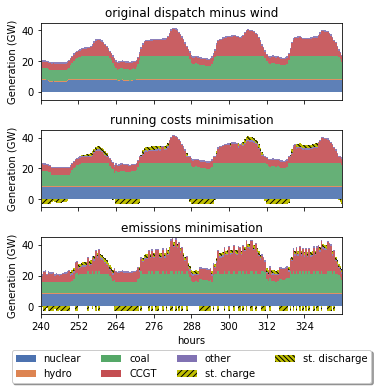

In [250]:
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(311)
bottomsPos = np.zeros(len(modelMix[window[0]*2:window[1]*2,:]))
for col in range(np.size(modelMix,1)):
    d = modelMix[window[0]*2:window[1]*2,col]
    ax1.bar(times, d, bottom=bottomsPos, width=0.5, color=colors[col], alpha=0.9)
    bottomsPos+=d
ax1.set_title('original dispatch minus wind')
ax1.set_xlim([window[0], window[1]])
tickLocs = np.arange(window[0], window[1], 12)
ax1.set_xticks(tickLocs)
ax1.set_xticklabels([''])
ax1.set_ylim([-5,45])
ax1.set_ylabel('Generation (GW)')

ax1 = fig.add_subplot(312)
bottomsPos = np.zeros(len(modelMixStFC[window[0]*2:window[1]*2,:]))
for col in range(np.size(modelMixStFC,1)):
    d = modelMixStFC[window[0]*2:window[1]*2,col]
    ax1.bar(times, d, bottom=bottomsPos, width=0.5, color=colors[col], alpha=0.9)
    bottomsPos+=d
ax1.bar(times, -storageDischargeFC[window[0]*2:window[1]*2], bottom=bottomsPos, width=0.5, \
        color='y', hatch='\\\\\\\\\\')
ax1.bar(times, -storageChargeFC[window[0]*2:window[1]*2], width=0.5, color='y', hatch='////')
ax1.set_title('running costs minimisation')
ax1.set_xlim([window[0], window[1]])
ax1.set_xticks(tickLocs)
ax1.set_xticklabels([''])
ax1.set_ylim([-5,45])
ax1.set_ylabel('Generation (GW)')

ax1 = fig.add_subplot(313)
bottomsPos = np.zeros(len(modelMixStEC[window[0]*2:window[1]*2,:]))
for col in range(np.size(modelMixStEC,1)):
    d = modelMixStEC[window[0]*2:window[1]*2,col]
    ax1.bar(times, d, bottom=bottomsPos, width=0.5, color=colors[col], alpha=0.9)
    bottomsPos+=d
ax1.bar(times, -storageDischargeEC[window[0]*2:window[1]*2], bottom=bottomsPos, width=0.5, \
        color='y', hatch='\\\\\\\\\\')
ax1.bar(times, -storageChargeEC[window[0]*2:window[1]*2], width=0.5, color='y', hatch='////')
ax1.set_title('emissions minimisation')
ax1.set_xlim([window[0], window[1]])
ax1.set_xticks(tickLocs)
tickLabs = [str(x) for x in tickLocs]
ax1.set_xticklabels(tickLabs)
ax1.set_ylim([-5,45])
ax1.set_ylabel('Generation (GW)')
ax1.set_xlabel('hours')

fig.tight_layout()

labZ = ['nuclear', 'hydro', 'coal', 'CCGT', 'other', 'st. charge', 'st. discharge']
rects = []
for col in range(np.shape(modelMixStEC)[1]-1):
    r = plt.Rectangle((0, 0), 1, 1, fc=colors[col], alpha=1)
    rects.append(r)
r = plt.Rectangle((0, 0), 1, 1, fc='y', hatch='////')
rects.append(r)
r = plt.Rectangle((0, 0), 1, 1, fc='y', hatch='\\\\\\\\\\')
rects.append(r)

ax1.legend(rects, labZ, loc='upper center', bbox_to_anchor=(0.5, -0.4),
          fancybox=True, shadow=True, ncol=4)

In [198]:
### create a matrix including wind
estimateMixFC = np.zeros((np.shape(genMatrixR)))
estimateMixFC[:,:-1] = modelMixStFC
estimateMixFC[:,-1] = wind-leftOverCurtFC

estimateMixEC = np.zeros((np.shape(genMatrixR)))
estimateMixEC[:,:-1] = modelMixStEC
estimateMixEC[:,-1] = wind-leftOverCurtEC

In [199]:
### remove OCGT from all mixes as uninteresting
estimateMixNew = np.zeros((len(estimateMix),np.shape(estimateMix)[1]-1))
estimateMixNew[:,0:5], estimateMixNew[:,-1] = estimateMix[:,0:5], estimateMix[:,-1]
estimateMixNewFC = np.zeros((len(estimateMixFC),np.shape(estimateMixFC)[1]-1))
estimateMixNewFC[:,0:5], estimateMixNewFC[:,-1] = estimateMixFC[:,0:5], estimateMixFC[:,-1]
estimateMixNewEC = np.zeros((len(estimateMixEC),np.shape(estimateMixEC)[1]-1))
estimateMixNewEC[:,0:5], estimateMixNewEC[:,-1] = estimateMixEC[:,0:5], estimateMixEC[:,-1]

In [200]:
estimateCols = ['nuclear', 'hydro', 'coal', 'CCGT', 'other', 'wind']
nGenTypes = len(estimateCols)

In [201]:
columns = ['genType','generation', 'optCat']
dataZ = np.zeros((len(estimateMix)*3*nGenTypes, 3))
index = np.arange(len(estimateMix)*3*nGenTypes)

In [202]:
for j in range(len(dataZ)):
    if j<len(estimateMixNew)*6:
        row, r = np.divmod(j,nGenTypes)
        dataZ[j,0] = r
        dataZ[j,1] = estimateMixNew[row,r]
        dataZ[j,2] = 0
    elif j<len(estimateMixNew)*12:
        row, r = np.divmod(j,nGenTypes)
        row = row-len(estimateMixNew)
        dataZ[j,0] = r
        dataZ[j,1] = estimateMixNewFC[row,r]
        dataZ[j,2] = 1
    else:
        row, r = np.divmod(j,nGenTypes)
        row = row-len(estimateMixNew)*2
        dataZ[j,0] = r
        dataZ[j,1] = estimateMixNewEC[row,r]
        dataZ[j,2] = 2

In [226]:
fs = 10
import matplotlib.lines as mlines

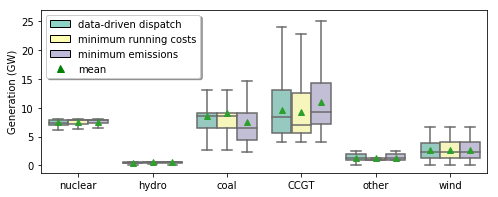

In [246]:
DF = pd.DataFrame(dataZ, index, columns);
fig = plt.figure(figsize=(8,3))
ax1 = fig.add_subplot(111)
sns.boxplot(x="genType", y="generation", hue="optCat", data=DF, flierprops=dict(marker='o', markersize=0),\
         width=0.8, showmeans=True, palette="Set3")
ax1.set_xticklabels(estimateCols);
ax1.set_ylabel('Generation (GW)', fontsize=fs)
ax1.set_xlabel('');
ax1.tick_params(axis='both',labelsize=fs)
# ax1.set_xlabel('User Load Shape', fontsize=fs), ax1.set_ylabel('Payback period (years)', fontsize=fs)

tri = mlines.Line2D([], [], color='green', marker='^', linestyle='None',
                          markersize=7, label='mean')
colorsSecond = sns.color_palette("Set3")
labOpt = ['data-driven dispatch', 'minimum running costs', 'minimum emissions']
rects = []
r1 = plt.Rectangle((0, 0), 1, 1, fc=colorsSecond[0], ec='k', alpha=1, label='data-driven dispatch')
r2 = plt.Rectangle((0, 0), 1, 1, fc=colorsSecond[1], ec='k', alpha=1, label='minimum running costs')
r3 = plt.Rectangle((0, 0), 1, 1, fc=colorsSecond[2], ec='k', alpha=1, label='minimum emissions')

ax1.legend(handles=[r1,r2,r3,tri], loc='upper left', fancybox=True, shadow=True, ncol=1, fontsize=fs)

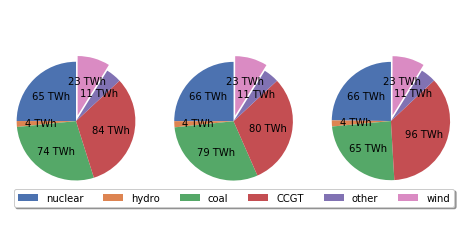

In [205]:
## Pie chart
def make_autopct1(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0)/1000)
        return '{v:d} TWh'.format(v=val)
    return my_autopct


fig1, axs = plt.subplots(1,3)
fig1.set_size_inches(8,4)

for j in range(3):
    if j == 0:
        plotMix = estimateMix
    if j == 1:
        plotMix = estimateMixFC
    if j == 2:
        plotMix = estimateMixEC 

    sizes = np.sum(plotMix, axis=0)/2.
    keep = np.array([0,1,2,3,4,6])
    sizes = sizes[keep]
    explode = (0,0,0,0,0,0.1)
    labZW = ['nuclear', 'hydro', 'coal', 'CCGT', 'other', 'wind']
    axs[j].pie(sizes, explode=explode, autopct=make_autopct1(sizes), shadow=False, startangle=90,
              colors=[colors[i] for i in keep])
    # Equal aspect ratio ensures that pie is drawn as a circle
    axs[j].axis('equal')
    
labZW = ['nuclear', 'hydro', 'coal', 'CCGT', 'other', 'wind']
rects = []
for col in range(5):
    r = plt.Rectangle((0, 0), 1, 1, fc=colors[col], alpha=1)
    rects.append(r)
r = plt.Rectangle((0, 0), 1, 1, fc=colors[6], alpha=1)
rects.append(r)
axs[1].legend(rects, labZW, loc='upper center', bbox_to_anchor=(0.5, 0.2),
          fancybox=True, shadow=True, ncol=7)

424.52812077640925
433.20514550499513
410.44056374093844


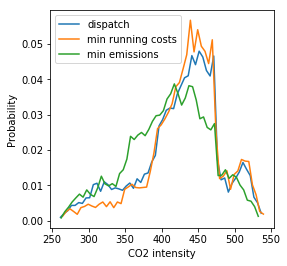

In [211]:
def demand_histogram(demand):
    upperVal = np.ceil(np.max(demand)/1)*1
    lowerVal = np.floor(np.min(demand)/1)*1
    demandBins = np.arange(lowerVal, upperVal+1, 5)
    hist, edges = np.histogram(demand, bins=demandBins)
    centres = edges[0:-1]+(edges[1:]-edges[0:-1])/2.
    widths = edges[1:]-edges[0:-1]
    return hist, centres, widths

def axis_format(axis, labX, labY, fs):
    axis.set_xlabel(labX, fontsize=fs)
    axis.set_ylabel(labY, fontsize=fs)
    axis.tick_params(axis='both', labelsize=fs)

### plot a histogram of carbon intensity
carbonByPeriod = np.sum(estimateMix*emissions, axis=1)/np.sum(estimateMix, axis=1)
hist, centres, widths = demand_histogram(carbonByPeriod)
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111)
l1, = ax1.plot(centres, hist/np.float(np.sum(hist)))#, width=widths, alpha=0.5)
print(np.mean(carbonByPeriod))

carbonByPeriod = np.sum(estimateMixFC*emissions, axis=1)/np.sum(estimateMixFC, axis=1)
hist, centres, widths = demand_histogram(carbonByPeriod)
l2, = ax1.plot(centres, hist/np.float(np.sum(hist)))#, width=widths, alpha=0.5)
print(np.mean(carbonByPeriod))

carbonByPeriod = np.sum(estimateMixEC*emissions, axis=1)/np.sum(estimateMixEC, axis=1)
hist, centres, widths = demand_histogram(carbonByPeriod)
l3, = ax1.plot(centres, hist/np.float(np.sum(hist)))#, width=widths, alpha=0.5)
print(np.mean(carbonByPeriod))

labX = 'CO2 intensity'
labY = 'Probability'
axis_format(ax1, labX, labY, fs)
ax1.legend([l1,l2,l3],['dispatch', 'min running costs', 'min emissions'])

In [214]:
totalGWh = np.sum(estimateMixEC, axis=0)
tonnesAnnualType = totalGWh*emissions
avEmissions = np.sum(tonnesAnnualType)/np.sum(totalGWh)
print ('model estimate that carbon intensity of UK grid is %.2f'%(avEmissions)+' g/kWh')

model estimate that carbon intensity of UK grid is 418.92 g/kWh


In [218]:
np.around(np.sum(estimateMixFC, axis=0), decimals=1)

array([132250.7,   8880.4, 158469.7, 160668.5,  22386.6,      0. ,
        46765.9])

In [219]:
np.around(np.sum(estimateMix, axis=0), decimals=1)

array([131583.2,   8410.6, 148982.3, 168830.9,  22426.5,      0. ,
        46441. ])

In [239]:
print('manually calculated objective function %.2f'\
      %((np.sum(np.sum(estimateMix, axis=0)*fuelCosts))/np.sum(estimateMix)))
print('manually calculated objective function %.2f'\
      %((np.sum(np.sum(estimateMixFC, axis=0)*fuelCosts))/np.sum(estimateMixFC)))
print('manually calculated objective function %.2f'\
      %((np.sum(np.sum(estimateMixEC, axis=0)*fuelCosts))/np.sum(estimateMixEC)))

manually calculated objective function 25.70
manually calculated objective function 25.43
manually calculated objective function 26.27


In [242]:
25.43/25.7

0.9894941634241246

In [243]:
print('manually calculated objective function %.2f'\
      %((np.sum(np.sum(estimateMix, axis=0)*emissions))/np.sum(estimateMix)))
print('manually calculated objective function %.2f'\
      %((np.sum(np.sum(estimateMixFC, axis=0)*emissions))/np.sum(estimateMixFC)))
print('manually calculated objective function %.2f'\
      %((np.sum(np.sum(estimateMixEC, axis=0)*emissions))/np.sum(estimateMixEC)))

manually calculated objective function 433.05
manually calculated objective function 438.88
manually calculated objective function 418.92


In [244]:
418.92/433.05

0.9673709733287149